In [1]:
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
# import pandas as ps
import time
import re
import os
import shutil
import glob
import math

In [2]:
TEST_ID = 'U.HO.03'
DATA_BITS = 32              #------------------ 16 doesn't work.
TRAIN_PERCENT= 90
BUFFER_SIZE = 20000
BATCH_SIZE = 8
LEARNING_RATE = 0.000005    #-------------------:
TEAM_EMBS = 50
LOSS_RAMBDA = 0.5
TRANSFORMER_DROP = 0.1      #--------------------:
TRANSFORMER_LAYERS = 6
TRANSFORMER_HEADS = 60
ADAPTORS_LAYERS = 10
RESET_HISTORY = False
MIN_PROFIT = -0.15
DISTRIBUTION_KEYS = [0.30, 0.10, 0.05, 0.02, 0.01, 0.00]
id_to_ids_filename = 'England-200-1e-07-7300-75-0.9-False'

In [3]:
if DATA_BITS == 32:
    NP_INT = np.int32; NP_FLOAT = np.float32; TF_INT = tf.int32; TF_FLOAT = tf.float32
elif DATA_BITS == 16:
    NP_INT = np.int16; NP_FLOAT = np.float16; TF_INT = tf.int16; TF_FLOAT = tf.float16

from config import config
config['np_int'] = NP_INT; config['np_flaot'] = NP_FLOAT; config['tf_int'] = TF_INT; config['tf_float'] = TF_FLOAT

import data_helpers
from data_generator import *

config types: <class 'numpy.int32'> <class 'numpy.float32'> <dtype: 'int32'> <dtype: 'float32'>


In [4]:
countryDirPath = "./data/football-data-co-uk/England"
df = data_helpers.get_master_df_from_football_data_co_uk(countryDirPath)

In [5]:
tokenizer_team = creat_team_tokenizer_uk(df)
print(tokenizer_team.get_vocab_size())

teams = ['Tottenham', 'Arsenal', 'Liverpool', 'what?', 'Tottenham', 'Chelsea', 'e_t', 'Man United', '1234', '[HOME]', '[AWAY]']
teams = [team.strip() for team in [re.sub(r"\s", "_", item) for item in teams]]
teams = " ".join(teams)
encoding = tokenizer_team.encode(teams)
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)

tokenizer_team.decode(encoding.ids)

113
['tottenham', 'arsenal', 'liverpool', '[UNK]', 'tottenham', 'chelsea', '[UNK]', 'man_united', '[UNK]', '[UNK]', '[UNK]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 4, 58, 0, 101, 27, 0, 62, 0, 0, 0]


'tottenham arsenal liverpool tottenham chelsea man_united'

In [6]:
class hyperparams:    
    nDivisions = 4 + 1  # E0, E1, E2, E3, and Unknown
    division_embs = 4
    nTeams = tokenizer_team.get_vocab_size()    # including Unknown
    team_embs = TEAM_EMBS
    nGoals  = 10  # 0 for 0 goals not for Unknown.
    goal_embs = 4
    nResults = 4    # HWin, Draw, AWin, and Unknown
    result_embs = 4
    # Mate d_model an even number!!!
    d_model = get_std_size()    + division_embs * len(Div_cols) + team_embs * len(Team_cols) \
                                + goal_embs * len(Goal_cols) + result_embs * len(Result_cols)
    batch_size = BATCH_SIZE
    days_spanning_years = 30
    num_layers = TRANSFORMER_LAYERS
    num_heads = TRANSFORMER_HEADS
    m365_size = 1
    initial_m365 = 0.9
    # d_model = team_emb_size * 2 + country_emb_size * 3 + odds_size + outcome_size

In [7]:
filepath = os.path.join(os.getcwd(), 'data', 'id_to_ids', id_to_ids_filename + '.json')
id_to_ids = data_helpers.LoadJsonData(filepath)

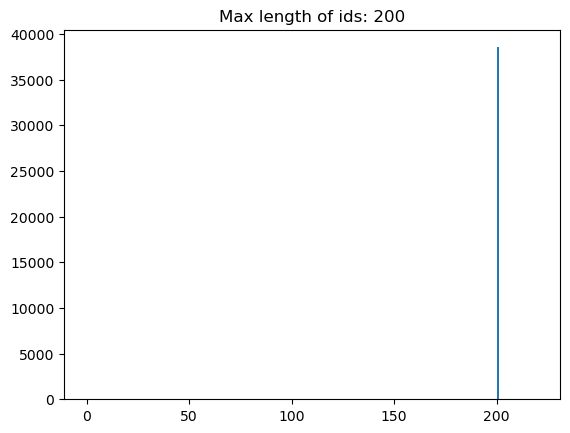

In [8]:
lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*1.1), int(maxLen*1.1) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

MAX_TOKENS = maxLen

In [9]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Result_cols = ['HTR', 'FTR']    # A function of Goal_cols, but contribute to better representation.
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols
_Cols_List_to_Embedd = [Div_cols, Team_cols, Goal_cols, Result_cols]
_Cols_List_to_Standardize = [Odds_cols, Shoot_cols, ShootT_cols, Corner_cols, Faul_cols, Yellow_cols, Red_cols]
_Cols_List_for_Label = [Full_Goal_cols, Odds_cols]
_Label_cols = Full_Goal_cols + Odds_cols

BBAB_cols = BB_cols + AB_cols
base_bbab = list(df.loc[df['id'] == 100000, BBAB_cols].iloc[0, :])
print(base_bbab)

[100000, 'E0', datetime.date(2004, 1, 11), 'Man_City', 'Norwich', 1.72, 3.4, 5.0, 1.7, 3.2, 5.0, 1.65, 3.3, 4.4, 1.66, 3.1, 5.0, 1.0, 0.0, 1, 1, 'H', 'D', 19.0, 10.0, 11.0, 5.0, 9.0, 4.0, 10.0, 13.0, 1.0, 0.0, 0.0, 0.0]


In [10]:
std_path = os.path.join('./data', 'datasets', id_to_ids_filename + ".json")
std_params = get_standardization_params(df)
print(std_params)
data_helpers.SaveJsonData(std_params, std_path)
std_params = data_helpers.LoadJsonData(std_path)

{'B365H': (3.1630270400481795, 1.4687447460469159, 46.0), 'HS': (11.39694154084398, 4.709404811489129, 43.0), 'HST': (4.815343915343916, 2.759941394538306, 24.0), 'HC': (5.34632855852368, 2.842282967456132, 24.0), 'HF': (11.421925409730287, 3.7612036770331043, 77.0), 'HY': (1.5455413601755066, 1.2348960213340971, 11.0), 'HR': (0.08013937282229965, 0.2855927650445304, 3.0)}


In [11]:
ds_path = os.path.join('./data', 'datasets', id_to_ids_filename + '_' + str(DATA_BITS))

if os.path.exists(ds_path):
    ds = tf.data.Dataset.load(ds_path)
else:
    ds = generate_dataset_uk(df, id_to_ids, tokenizer_team, std_params)
    tf.data.Dataset.save(ds, ds_path)
    ds = tf.data.Dataset.load(ds_path)

len(ds)

38745

In [12]:
dataset_size = len(ds)
train_size = int(TRAIN_PERCENT/100 * dataset_size)
test_size = dataset_size - train_size

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)

print(len(train_ds), len(test_ds), len(ds), len(ds)-len(train_ds)-len(test_ds))

34870 3875 38745 0


In [13]:
dummy_bbas_tensor = get_dummy_bbas_tensor_uk(df, tokenizer_team, std_params)

In [14]:
def normalize_row(baseId, sequence, base_bb, base_label):
    try:
        seq_len_org = sequence.shape[0]
        nMissings = MAX_TOKENS - seq_len_org
        if nMissings > 0:
            block = tf.stack([dummy_bbas_tensor] * nMissings, axis=0)
            sequence = tf.concat([sequence, block], axis=0) 
        # print("sequence 1", sequence.shape)
        # sequence[:, 2] = base[2] - sequence[:, 2]   # get delta days.
        base_bb = base_bb[tf.newaxis, :]    # shape: (seq_len = 1, nFeatures)
        mask = tf.Variable([1] * seq_len_org + [0] * nMissings, dtype=TF_INT) ## DO NOT USE tf.constant !!! unstable.
        mask = mask[:, tf.newaxis] & mask[tf.newaxis, :]
        # print('normalize', sequence.shape, base.shape, mask.shape, mask)
        # seq_len_org = tf.Variable(seq_len_org, dtype=TF_INT)    #--------------------------------- comeback
        return (baseId, sequence, base_bb, base_label, mask, seq_len_org)
    except:
        print('normalize_row exception')
        print('norm 1', sequence.shape, base_bb.shape, base_label.shape, mask.shape, nMissings)
        print('norm 2', baseId, sequence, base_label, mask, nMissings)
        # return (baseId, sequence, base_bb, base_label, mask, seq_len_org)

def prepare_batch(baseId, sequence, base_bb, base_label, mask, seq_len_org):
    # target = tf.one_hot(tf.squeeze(tf.cast(base_bbab[:, :, -1], dtype=TF_INT), axis=-1), hyperparams.target_onehot_size)
    return (baseId, sequence, base_bb, mask), (base_label, seq_len_org)     # (X, Y)

def normalize_dataset(ds):
    return (
        ds.map(lambda baseId, sequence, base_bb, base_label: tf.py_function(
            func=normalize_row,
            inp=[baseId, sequence, base_bb, base_label],
            Tout=[TF_INT, TF_FLOAT, TF_FLOAT, TF_FLOAT, TF_INT, TF_INT])) #, tf.data.AUTOTUNE == Instability!!!
        )

def make_train_batches(ds):
    return (
        ds
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

def make_test_batches(ds):
    return (
        ds
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

In [15]:
train_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename + '_train_' + str(TRAIN_PERCENT) + '_' + str(DATA_BITS))
if os.path.exists(train_ds_path):
    train_ds = tf.data.Dataset.load(train_ds_path)
else:
    train_ds = normalize_dataset(train_ds)
    tf.data.Dataset.save(train_ds, train_ds_path)

print(len(train_ds))

train_batches = make_train_batches(train_ds)

34870


In [16]:
test_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename + '_test_' + str(TRAIN_PERCENT) + '_' + str(DATA_BITS))
if os.path.exists(test_ds_path):
    test_ds = tf.data.Dataset.load(test_ds_path)
else:
    test_ds = normalize_dataset(test_ds)
    tf.data.Dataset.save(test_ds, test_ds_path)

print(len(test_ds))

test_batches = make_test_batches(test_ds)

3875


In [17]:
def positional_encoding(memory, depth):
    positions = tf.range(memory.shape[-1], dtype=TF_FLOAT)
    fractional_pos = memory * positions    # fractional position: (batch, fractional position #)
    depth = depth/2
    depths = tf.range(depth, dtype=TF_FLOAT) / depth
    depths = tf.pow(10000.0, depths)    # (depth,)
    angle_rads = fractional_pos[:, :, tf.newaxis] / depths  # (batch, fractional position #, depth)
    # pos_encoding = rearrange([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], 'w b p d -> w h (w t)')
    pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)
    return pos_encoding

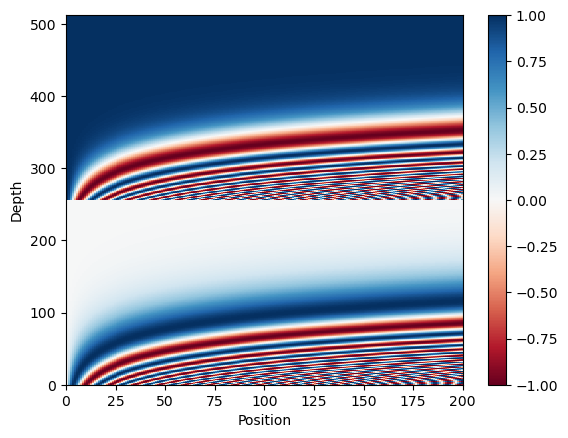

In [18]:
memory = tf.ones((100, 200), dtype=TF_FLOAT) * 0.5
pos_encoding = positional_encoding(memory, depth=512)
# print('pos_encoding', pos_encoding.shape)
pos_encoding = pos_encoding[0, :, :]
# print(pos_encoding.shape)
# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [19]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Result_cols = ['HTR', 'FTR']    # A function of Goal_cols, but contribute to better representation.
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

In [20]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, hyperparams, isEncoder=True):
    super().__init__()
    self.isEncoder = isEncoder
    self.division_embedding = tf.keras.layers.Embedding(hyperparams.nDivisions, hyperparams.division_embs, dtype=TF_FLOAT, mask_zero=False) # Learn Unknown
    self.team_embedding = tf.keras.layers.Embedding(hyperparams.nTeams, hyperparams.team_embs, dtype=TF_FLOAT, mask_zero=False) # Learn Unknown
    self.goal_embedding = tf.keras.layers.Embedding(hyperparams.nGoals, hyperparams.goal_embs, dtype=TF_FLOAT, mask_zero=False) # Learn 0-goal
    self.result_embedding = tf.keras.layers.Embedding(hyperparams.nResults, hyperparams.result_embs, dtype=TF_FLOAT, mask_zero=False) # Learn Unknown

    self.d_model = hyperparams.d_model
    # print(self.d_model)
    self.position_permuting_dense = tf.keras.layers.Dense(self.d_model)
    self.m365_embedding = tf.keras.layers.Embedding(1, hyperparams.m365_size, mask_zero=False, embeddings_initializer = tf.keras.initializers.Ones())

    self.idx_Days = BB_cols.index('Date')
    assert self.idx_Days == BBAB_cols.index('Date')

  def call(self, x):
    (sequence, base_bb, mask) = x # sob = sequence or base_bb
    sDays = sequence[:, :, self.idx_Days]
    bDays = base_bb[:, :, self.idx_Days]
    
    # BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
    # AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

    sob = None
    if self.isEncoder:
      sob = sequence
    else:
      sob = base_bb

    if self.isEncoder:
      # Extract odds to remove them
      id, div, days, teams, odds, goals, results, remainder \
      = tf.split(sob, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), len(Goal_cols), len(Result_cols),  -1], axis=-1)
      # print('1', remainder[0, 0])
    else:
      # Extract odds to remove them
      id, div, days, teams, odds, remainder \
      = tf.split(sob, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)  
      # print('2', remainder[0, 0])  

    # print('pe 2.7.1 1', div)
    div = self.division_embedding(tf.cast(div, dtype=TF_INT))
    div = tf.reshape(div, [div.shape[0], div.shape[1], -1])
    # print('pe 2.7.1 1', div)
    teams = self.team_embedding(tf.cast(teams, dtype=TF_INT))
    teams = tf.reshape(teams, [teams.shape[0], teams.shape[1], -1])
    if self.isEncoder:
      goals = self.goal_embedding(tf.cast(goals, dtype=TF_INT))
      goals = tf.clip_by_value(goals, 0, hyperparams.nGoals)
      goals = tf.reshape(goals, [goals.shape[0], goals.shape[1], -1])
      results = self.result_embedding(tf.cast(results, dtype=TF_INT))
      results = tf.reshape(results, [results.shape[0], results.shape[1], -1])
    
    if self.isEncoder:
      concat = [div, teams, goals, results, odds, remainder]
    else:
      concat = [div, teams, odds, remainder]

    sob = tf.concat(concat, axis=-1)
    sob = self.position_permuting_dense(sob)

    days_ago = tf.cast(bDays - sDays, dtype=TF_FLOAT) if self.isEncoder else tf.cast(bDays - bDays, dtype=TF_FLOAT)
    
    m365 = self.m365_embedding(tf.zeros_like((hyperparams.m365_size,), dtype=TF_FLOAT)) * hyperparams.initial_m365  # expected shape: (1, hyperparams.remain_365_size)
    m365 = tf.squeeze(m365, axis=0)
    memory_alpha = tf.math.pow(m365, 1.0/365) # (hyperparams.m365_size,)
    memory = tf.math.pow(memory_alpha, tf.cast(days_ago[:, :, tf.newaxis], tf.float32))  # decrease as days_ago increase, if memory <= 1.0 as expected.
    memory = tf.reduce_mean(memory, axis=-1)

    pe = positional_encoding(memory, depth=sob.shape[-1]) # (batch, d_model)
    pe = pe / tf.math.sqrt(tf.cast(sob.shape[-1], TF_FLOAT))
    sob = sob + pe

    if self.isEncoder:
      mask = mask
    else:
      mask = mask[:, 0:sob.shape[1], :]

    return (sob, mask)

In [21]:
pos = PositionalEmbedding(hyperparams, isEncoder=True)

cnt = 3
for z in train_batches:
    (baseId, sequence, base_bb, mask), (base_label, seq_len_org) = z
    cnt -= 1
    if cnt == 0: break
print('baseId', baseId)
sample_x = (sequence, base_bb, mask)
sample_y = (base_label, seq_len_org)
eSob, eMask = pos.call(sample_x)
print(eSob.shape, eMask.shape)

baseId tf.Tensor([118848 128641 118116 103683 122376 110257 130609 109925], shape=(8,), dtype=int32)
(8, 200, 152) (8, 200, 200)


In [22]:
PE = PositionalEmbedding(hyperparams, isEncoder=True)
eSob, eMask = PE(sample_x)
print(eSob.shape, eMask.shape )
del PE

(8, 200, 152) (8, 200, 200)


In [23]:
PE = PositionalEmbedding(hyperparams, isEncoder=False)
dSob, dMask = PE(sample_x)
print(dSob.shape, dMask.shape )
del PE

(8, 1, 152) (8, 1, 200)


In [24]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super().__init__()
      self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
      self.layernorm = tf.keras.layers.LayerNormalization()   # So the default -1 axix is normalized across. No inter-token operatoin.
      self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context, mask):
      attn_output, attn_scores = self.mha(
          query=x,
          key=context,
          value=context,
          attention_mask=mask,
          return_attention_scores=True)
    
      # Cache the attention scores for plotting later.
      self.last_attn_scores = attn_scores
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class GlobalSelfAttention(BaseAttention): 
    def call(self, x, mask):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x,
          attention_mask=mask)    # intentional inter-token operation
      x = self.add([x, attn_output])  # token-wise
      x = self.layernorm(x)         # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class CausalSelfAttention(BaseAttention): # mask-agnostic
    def call(self, x):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x,
          use_causal_mask = True)     # look-over mask is generagted and used, in decoder layers
      x = self.add([x, attn_output])  # mask-agnostic
      x = self.layernorm(x)  # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),    # across -1 axis
        tf.keras.layers.Dense(d_model),    # across -1 axis
        tf.keras.layers.Dropout(dropout_rate)    # mask-agnostic
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      x = self.add([x, self.seq(x)])  # mask-agnostic
      x = self.layer_norm(x)  # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
      super().__init__()

      self.self_attention = GlobalSelfAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)

      self.ffn = FeedForward(d_model, dff)

    def call(self, x, mask):
      # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.self_attention(x, mask)
      x = self.ffn(x)
      return x
  
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hyperparams, dropout_rate=0.1):
      super().__init__()

      self.d_model = hyperparams.d_model
      self.num_layers = hyperparams.num_layers

      self.pos_embedding = PositionalEmbedding(hyperparams)

      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.enc_layers = [
          EncoderLayer(d_model=hyperparams.d_model,
                      num_heads=hyperparams.num_heads,
                      dff=hyperparams.d_model * 4,
                      dropout_rate=dropout_rate)
          for _ in range(hyperparams.num_layers)]

    def call(self, x):
      # x = (sequence, base_bb, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (token, max_tokens, max_tokens)
      x, mask = self.pos_embedding(x)  # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.dropout(x)
      for encoder_layer in self.enc_layers:
        x = encoder_layer(x, mask)
      return x  # Shape `(batch_size, seq_len, d_model)`.
  
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
      super(DecoderLayer, self).__init__()

      self.causal_self_attention = CausalSelfAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)
      
      self.cross_attention = CrossAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)

      self.ffn = FeedForward(d_model, dff)

    def call(self, x, context, cross_attention_mask):
      # x: (batch, 1, d_model), context: (batch, max_tokens, d_mode)
      x = self.causal_self_attention(x=x)
      x = self.cross_attention(x, context, cross_attention_mask)

      # Cache the last attention scores for plotting later
      self.last_attn_scores = self.cross_attention.last_attn_scores

      x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
      return x
  
class Decoder(tf.keras.layers.Layer):
    def __init__(self, hyperparams, dropout_rate=0.1):
      super(Decoder, self).__init__()

      self.d_model = hyperparams.d_model
      self.num_layers = hyperparams.num_layers

      self.pos_embedding = PositionalEmbedding(hyperparams, isEncoder=False)

      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.dec_layers = [
          DecoderLayer(d_model=hyperparams.d_model, num_heads=hyperparams.num_heads,
                      dff=hyperparams.d_model * 4, dropout_rate=dropout_rate)
          for _ in range(hyperparams.num_layers)]

      self.last_attn_scores = None

    def call(self, x, context):
      # x = (sequence, base_bb, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (token, max_tokens, max_tokens)
      # context: (batch, max_tokens, d_model)
      # `x` is token-IDs shape (batch, target_seq_len)
      x, ca_mask = self.pos_embedding(x)  # x: (batch, 1, d_model), ca_mask: (batch, 1, max_tokens)     
      x = self.dropout(x)
      for decoder_layer in self.dec_layers:
        x  = decoder_layer(x, context, ca_mask)
      self.last_attn_scores = self.dec_layers[-1].last_attn_scores
      return x
  
class Transformer(tf.keras.Model):
    def __init__(self, hyperparams, dropout_rate=0.1):
      super().__init__()
      self.encoder = Encoder(hyperparams, dropout_rate=dropout_rate)

      self.decoder = Decoder(hyperparams, dropout_rate=dropout_rate)

      self.final_layer = tf.keras.layers.Dense(hyperparams.d_model) #-------------- to modify

    def call(self, inputs):
      # inputs = (sequence, base_bb, mask)
      # sequence: (batch, max_token, aabb), base: (batch, 1, bb), mask: (batch, max_token, max_token)
      x = self.encoder(inputs)  # (batch, max_tokens, d_model)
      x = self.decoder(inputs, x)  # (batch, 1, d_model)
      logits = self.final_layer(x)  # (batch, 1, d_model)
      logits = tf.squeeze(logits, axis=-2)  # (batch, d_model)
      return logits

In [25]:
sample_transformer = Transformer(hyperparams)
y = sample_transformer(sample_x)

sample_transformer.summary()
del sample_transformer

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  34581015  
                                                                 
 decoder (Decoder)           multiple                  68012143  
                                                                 
 dense_29 (Dense)            multiple                  23256     
                                                                 
Total params: 102,616,414
Trainable params: 102,616,414
Non-trainable params: 0
_________________________________________________________________


In [26]:
class HappenAdaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hyperparams.d_model + round( (d_output - hyperparams.d_model) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, activation='sigmoid') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

In [27]:
class BettingEPL(tf.keras.Model):
  def __init__(self, hyperparams, nQueries, loss_rambda=1.0, dropout_rate=0.1):
    super().__init__()
    self.nQueries = nQueries
    self.transformer = Transformer(hyperparams, dropout_rate=dropout_rate)
    self.happenAdaptor = HappenAdaptor(ADAPTORS_LAYERS, self.nQueries)
    self.softmax = tf.keras.layers.Softmax(axis=-1)
    self.cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction="sum_over_batch_size")
    self.bookies = ['B365', 'Betfair', 'Interwetten', 'William']
    # self.qGroups = [QGroup1X2(bookie) for bookie in self.bookies]
    self.rambda = loss_rambda     #----------------------- Sensitive rambda!!!, Automate optimizing it.
    # self.shift_embedding = tf.keras.layers.Embedding(1, hyperparams.m365_size, mask_zero=False, embeddings_initializer = tf.keras.initializers.Ones())
    # self.shift = None

  def h_true(self, ftGoals):  # Defines this QGroup. This is for 1X2 QGroup. Derived classes re-define this funciton.
    # ftGoals:  (batch, 2)
    ftGoals = tf.cast(ftGoals, dtype=TF_INT)  # (batch, 2)
    h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
    h = tf.cast(tf.transpose(h), dtype=TF_FLOAT)  # (batch, nQueries)
    return h

  def call(self, input):
      x = self.transformer(input)   # (batch, d_model)
      happenBase = self.happenAdaptor(x)  # (batch, nQuereis)
      happen_prob = self.softmax(happenBase)
      return happen_prob  # (batch, nQueries)
  
  def loss(self, y, happen_prob):   
      # y: (batch, len(Team_cols)+len(Odds_cols)) 
      # happen_prob: # (batch, nQueries)
      ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, sum[qGropu.nQueries for qGroup in self.qGroups])
      odds_by_qGroup = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [ shape: (batch, qGroup.nQueries) for qGroup in self.qGroups ]
      mean_odds = tf.stack(odds_by_qGroup, axis=-1)  # (batch, nQuereis, nQGroups)
      mean_odds = tf.math.reduce_mean(mean_odds, axis=-1)  # (batch, nQueries)
      happen_t = self.h_true(ftGoals) # (batch, nQueries)
      loss = mean_odds * (happen_t + self.rambda) * self.cce(happen_t, happen_prob) # (batch, nQueries). NOT a one-non-zero
      loss = tf.math.reduce_sum(loss, axis=None)  # ()
      return loss
  
  def back_test(self, y, happen_prob, keys):
    # y: (batch, len(Team_cols)+len(Odds_cols)) 
    # happen_prob: # (batch, nQueries)

    ftGoals, odds = tf.split(y, [2, -1], axis=-1)
    odds_by_qGroup = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nQGroups
    odds = tf.stack(odds_by_qGroup, axis=0) # (nQGroups, batch, nQueries)
    
    idx = tf.argmax(happen_prob, axis=-1) # (batch,)
    happen_p = tf.one_hot(idx, tf.shape(happen_prob)[-1], axis=-1)  # (batch, nQueries)
    profit_p = (odds * happen_p - 1.0) * happen_p   # (nQGroups, batch, nQueries). One-non-zero
    profit_p = tf.math.reduce_sum(profit_p, axis=-1)  # (nQGroups, batch)
    profit_p = tf.transpose(profit_p)   # (batch, nQGroups)

    happen_t = self.h_true(ftGoals)   # (batch, nQueries)
    # print(happen_t)
    profit_back = (odds * happen_t - 1.0) * happen_p  # (nQGroups, batch, nQueries). One-non-zero
    profit_back = tf.math.reduce_sum(profit_back, axis=-1)  # (nQGroups, batch)
    profit_back = tf.transpose(profit_back)   # (batch, nQGroups)
    # print(profit_back)

    profit_back_mean_per_betting_list = []
    nBettings_list = []

    for key in keys:
      best_idx = tf.where(profit_p > key)  # (nBettings, 2). nBettings unknown yet.

      nBettings = 0
      profit_back_mean_per_betting = MIN_PROFIT
      if best_idx.shape[0] > 0:
        best_profits_back = tf.gather_nd(profit_back, best_idx)   # (nBettings, )
        nBettings = best_profits_back.shape[0]
        profit_back_mean_per_betting = tf.math.reduce_mean(best_profits_back)
      profit_back_mean_per_betting_list.append(float(profit_back_mean_per_betting))
      nBettings_list.append(nBettings)
    return profit_back_mean_per_betting_list, nBettings_list

In [28]:
EPL = BettingEPL(hyperparams, 3, loss_rambda = LOSS_RAMBDA, dropout_rate=TRANSFORMER_DROP)

happen_prob = EPL(sample_x, training=True)
loss = EPL.loss(sample_y[0], happen_prob)

profit_list, nBettings_list = EPL.back_test(sample_y[0], happen_prob, DISTRIBUTION_KEYS)
# print(profit_list)
# print(nBettings_list)

EPL.summary()

Model: "betting_epl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_1 (Transformer)  multiple                 102616414 
                                                                 
 happen_adaptor (HappenAdapt  multiple                 78483     
 or)                                                             
                                                                 
 softmax_18 (Softmax)        multiple                  0         
                                                                 
Total params: 102,694,897
Trainable params: 102,694,897
Non-trainable params: 0
_________________________________________________________________


In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, TF_FLOAT)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=TF_FLOAT)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [30]:
# learning_rate = CustomSchedule(hyperparams.d_model)

learning_rate = LEARNING_RATE
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.95, beta_2=0.95, epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adadelta()

In [31]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss_uk(label, y_pred):
  # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch, 1)), y_pred: (batch, 3)
  y_true = label[0]   # one_hot: (batch, 3)
  seq_len = label[2]  # (batch, 1)

  mask = y_true != 0 
  loss = loss_object(y_true, y_pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask) # eq. sum_loss / batch
  return loss


class recall():
  def __init__(self, name='recall', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.recall = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=TF_FLOAT)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    # print('recall', y_true.shape, y_pred.shape, seq_len_mask.shape)

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    # print('recall', true_positives.numpy())
    possible_positives = tf.math.reduce_sum(y_true)
    recall_keras = true_positives / (possible_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.recall = self.recall * (self.n-1)/self.n + recall_keras.numpy() / self.n


  def result(self):
    return self.recall
  
  def reset(self):
    self.n = 0
    self.recall = 0.0
  
recall_object = recall(min_seq_len=5)

class precision():
  def __init__(self, name='precision', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.precision = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch, 1)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=TF_FLOAT)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    predicted_positives = tf.math.reduce_sum(y_pred)
    precision_keras = true_positives / (predicted_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.precision = self.precision * (self.n-1)/self.n + precision_keras.numpy() / self.n

  def result(self):
    return self.precision
  
  def reset(self):
    self.n = 0
    self.precision = 0.0

precision_object = precision(min_seq_len=5)

In [32]:
@tf.function
def train_step(x, y):
    
    with tf.GradientTape() as tape:
        outputs = EPL(x, training=True)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
        loss_value = EPL.loss(y, outputs)
    
    grads = tape.gradient(loss_value, EPL.trainable_weights)
    optimizer.apply_gradients(zip(grads, EPL.trainable_weights))
    # recall_object.update_state(y, logits)
    # precision_object.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    outputs = EPL(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    loss_value = EPL.loss(y, outputs)
    # recall_object.update_state(y, val_logits)
    # precision_object.update_state(y, val_logits)
    return loss_value

# @tf.function  #-------------------- Wierd: no work.
def test_with_dataset(dataset):
    n = 0
    val_loss = tf.Variable(0.0, dtype=TF_FLOAT)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, mask); y = base_label
        n += 1
        val_loss = val_loss * (n-1) / n + test_step(x, y) / n   ###
    return val_loss

In [33]:
# @tf.function  # gives a wrong result of tf.where(profit_p > key)
def back_test_step(x, y, keys):
    outputs = EPL(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    profit_back_mean_per_betting, nBettings = EPL.back_test(y, outputs, keys)
    # print('key', profit_back_mean_per_betting, nBettings)
    return profit_back_mean_per_betting, nBettings

# @tf.function  #-------------------- Wierd: no work.
def back_test_with_dataset(dataset, keys):
    profit_back_mean = [MIN_PROFIT] * len(keys)
    nBettingsTotal = [0] * len(keys)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, mask); y = base_label
        profit_list, nBettings_list = back_test_step(x, y, keys)

        for profit, nBettings, id in zip(profit_list, nBettings_list, range(len(keys))):
            if nBettings > 0:
                profit_back_mean[id] = (profit_back_mean[id] * nBettingsTotal[id] + profit * nBettings) / (nBettingsTotal[id] + nBettings)
                nBettingsTotal[id] = nBettingsTotal[id] + nBettings

    # print('key', profit_back_mean, nBettingsTotal)
    return profit_back_mean, nBettingsTotal

class history_class():
    def round_sig(self, x, sig=2):
            return x
            # return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self):
        self.history = {'loss': [], 'val_loss': []}
    def save(self, path):
        data_helpers.SaveJsonData(self.history, path)
    def load(self, path):
        history = data_helpers.LoadJsonData(path)
        if history is not None:
            self.history = history
    def append(self, loss, val_loss):
        self.history['loss'].append(self.round_sig(float(loss), 4))
        self.history['val_loss'].append(self.round_sig(float(val_loss), 4))
    def len(self):
        assert len(self.history['loss']) == len(self.history['val_loss'])
        return len(self.history['loss'])
    def get_latest_item(self):
        return (self.history['loss'][-1], self.history['val_loss'][-1])
    def get_min_val_loss(self):
        return float('inf') if self.len() <= 0 else min(self.history['val_loss'])

    def show(self, ax):
        ax.set_title(TEST_ID + ": loss history")
        ax.plot(self.history['loss'])
        ax.plot(self.history['val_loss'])
        ax.grid(True)
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch')
        ax.legend(['train_loss', 'val_loss'], loc='upper left')

class backtest_class():
    def round_sig(self, x, sig=2):
            return x
            # return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self, keys):
        self.keys = keys
        self.avg_profit = {str(key): [] for key in self.keys}
        self.nBettings = {str(key): [] for key in self.keys}
    def save(self, path):
        data_helpers.SaveJsonData([self.avg_profit, self.nBettings], path)
    def load(self, path):
        backtest = data_helpers.LoadJsonData(path)
        if backtest is not None:
            [self.avg_profit, self.nBettings] = backtest

    def getLen(self, dict):
        length = None
        try:
            for key, value in dict.items():
                if length is None:
                    length = len(value)
                else:
                    assert len(value) == length
            return length
        except:
            raise Exception("Un-uniform length in  distribution")      

    def len(self):
        assert len(self.avg_profit) == len(self.keys)
        assert len(self.nBettings) == len(self.keys)
        length = self.getLen(self.avg_profit)
        assert self.getLen(self.nBettings) == length
        return length

    def append(self, avg_profit_list, nBettings_list):
        length = self.len()     # for all the asserts.
        assert len(avg_profit_list) == len(self.keys)
        for item_list, item in zip(self.avg_profit.values(), avg_profit_list):
            item_list.append(item)

        assert len(nBettings_list) == len(self.keys)
        for item_list, item in zip(self.nBettings.values(), nBettings_list):
            item_list.append(item)

    def show(self, ax):
        colors = ['black', 'firebrick', 'darkgreen', 'c', 'blue', 'blueviolet', 'magenta', 'maroon', "yellowgreen", 'cadetblue', 'purple']

        gmin = 0.0; gmax = 1.0
        all_profits = []
        for item_list in self.avg_profit.values():
            all_profits += item_list
        if len(all_profits) > 0:
            gmin = min(all_profits); gmax = max(all_profits)
        
        _min = 0.0; _max = 1.0
        all_nBettings = []
        for item_list in self.nBettings.values():
            all_nBettings += item_list
        if len(all_nBettings) > 0:
            _min = min(all_nBettings); _max = max(all_nBettings)
        
        legends = []
        for item_list, color, key in zip(self.avg_profit.values(), colors[:len(self.keys)], self.keys):
            # print(item_list, color, key)
            ax.plot(item_list, color=color, linewidth=0.7)
            legends.append("> " + str(key))
        # print(legends)
        for item_list, color in zip(self.nBettings.values(), colors[:len(self.keys)]):
            item_list = [ (item-_min)/(_max-_min+1e-9) * (gmax-gmin) + gmin for item in item_list]
            ax.plot(item_list, color=color, linestyle='--', linewidth=0.7)
        ax.legend(legends, loc='upper left')
        ax.grid(True)
        ax.set_title(TEST_ID + ": avg_profit and scaled nBettings per (>) threshold key.")
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch')

checkpointPath = os.path.join('./data', 'checkpoints', TEST_ID + '_weights')
checkpointPathBest = os.path.join('./data', 'checkpoints', TEST_ID + '_weights_best')
historyPath = os.path.join('./data', 'checkpoints', TEST_ID + '_history.json')
backtestPath = os.path.join('./data', 'checkpoints', TEST_ID + '_backtest.json')

history = history_class()
backtest = backtest_class(DISTRIBUTION_KEYS)

def removeFile(path):
    files = glob.glob(path + "*")   # "*.*" may not work
    result = [os.remove(file) for file in files]
    return

if RESET_HISTORY:
    removeFile(checkpointPath)
    removeFile(checkpointPathBest)
    removeFile(historyPath)
    history.save(historyPath)
    removeFile(backtestPath)
    backtest.save(backtestPath)

try: 
    EPL.load_weights(checkpointPath)
except:
    print('Failed to load model weights.')

history.load(historyPath)
backtest.load(backtestPath)

In [34]:
print(history.history['loss'])

[65.83094024658203, 65.23416900634766, 64.88375091552734, 64.68275451660156, 64.56005096435547, 64.4825668334961, 64.44361877441406, 64.4088134765625, 64.3952865600586, 64.37554931640625, 64.36688995361328, 64.36618041992188, 64.35501861572266, 64.3525619506836, 64.34223175048828, 64.33641052246094, 64.33431243896484, 64.32537841796875, 64.32809448242188, 64.32976531982422, 64.32188415527344, 64.31490325927734, 64.30435943603516, 64.31816864013672, 64.31429290771484, 64.3018569946289, 64.3030776977539, 64.30471801757812, 64.30744934082031, 64.2893295288086, 64.28556060791016, 64.2740249633789, 64.26805114746094]


In [35]:
def save_checkpoint(loss, val_loss, prifit_list, nBettings_list):
    EPL.save_weights(checkpointPath)
    min_val_loss = history.get_min_val_loss()
    if val_loss < min_val_loss:
        EPL.save_weights(checkpointPathBest)
    history.append(loss, val_loss)
    history.save(historyPath)
    backtest.append(prifit_list, nBettings_list)
    backtest.save(backtestPath)

def show_steps(epoch, step, loss, samples_seen):
    # recall = recall_object.result()
    # precision = precision_object.result()
    # print("epoch: {}, step: {}, loss: {}, recall: {}, precision: {}, samples_seen: {}".
    #       format(epoch, step, float(loss_value), recall, precision, (step + 1) * hyperparams.batch_size))
    print("epoch: {}, step: {}, loss: {}, samples_seen: {}          ".
            format(epoch, step, float(loss), samples_seen), end='\r')
    # recall_object.reset()
    # precision_object.reset()

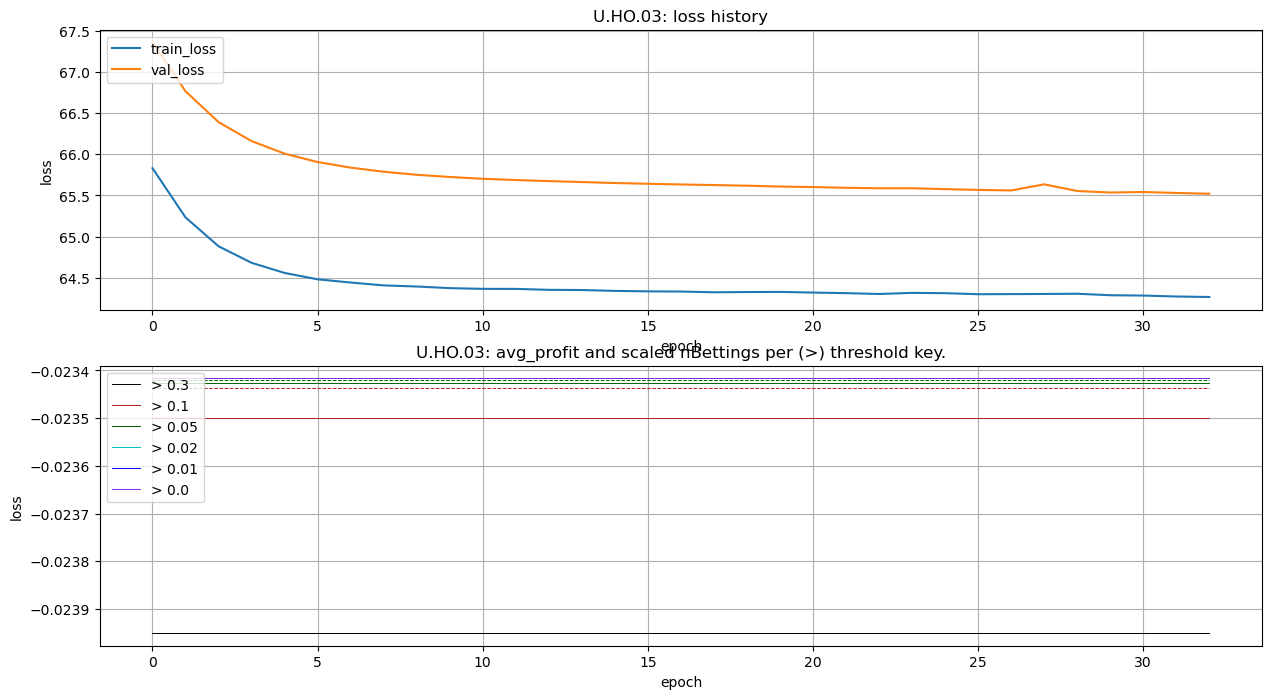

In [36]:
epochs = 500
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
history.show(axes[0]); backtest.show(axes[1]); plt.show()
for epoch in range(history.len(), epochs):
    start_time = time.time()
    history.show(axes[0]); backtest.show(axes[1]); plt.show()
    n = 0; loss = tf.Variable(0.0, dtype=TF_FLOAT); samples_seen = 0
    m = 0; epoch_loss = 0.0
    
    train_batches = make_train_batches(train_ds)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(train_batches):
        x = (sequence, base_bb, mask); y = base_label
        batch_loss = train_step(x, y)
        n += 1; loss = loss * (n-1)/n + batch_loss/n
        m += 1; epoch_loss = epoch_loss * (m-1)/m + batch_loss/m

        samples_seen += sequence.shape[0]
        if step % 50 == 0:
            show_steps(epoch, step, loss, samples_seen)
            n = 0; loss = 0.0

    show_steps(epoch, step, loss, samples_seen)
    val_loss = test_with_dataset(test_batches)
    profit_list, nBettings_list = back_test_with_dataset(test_batches, backtest.keys)
    save_checkpoint(epoch_loss, val_loss, profit_list, nBettings_list)

    eM365W = EPL.layers[0].layers[0].get_weights()[6]; eM365W = list(tf.reshape(eM365W, (-1,)).numpy())

    print("epoch: {}, loss: {}, val_loss: {}, profit: {}, nBettings: {}, memory365: {:.4f},  time taken: {:.1f}m                      "
          .format(epoch, float(epoch_loss), float(val_loss), profit_list, nBettings_list, eM365W[0] * hyperparams.initial_m365, (time.time()-start_time)/60))